In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [2]:
# driver mount
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import os
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
# from PIL import Image, ImageDraw
print('tf version :',tf.__version__)
print('tf gpu available :',tf.test.is_gpu_available())

tf version : 2.0.0
tf gpu available : True


In [4]:
#Load preprocessed quick_draw_data at my google drive   
root = 'drive/My Drive/quick_draw_text2image'
path = '/'

x_train = np.load(root+path+'x_train.npy')
y_train = np.load(root+path+'y_train.npy')
print('train data & labels shape:',x_train.shape, y_train.shape)

with open(root+path+'nums2class.pickle', 'rb') as f:
    num2class = pickle.load(f)
print('number of classes :',len(num2class))

train data & labels shape: (26640, 64, 64) (26640,)
number of classes : 340


1.0


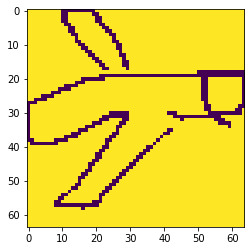

In [0]:
real_images = x_train[..., tf.newaxis] # (26640, 64,64,1)
print('real_image shape :', real_images.shape)
train_ds = tf.data.Dataset.from_tensor_slices(real_images).shuffle(10000).batch(32)

real_image shape : (26640, 64, 64, 1)


In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model

In [0]:
generator = make_generator_model()
# tf.keras.utils.plot_model(generator)

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
discriminator = make_discriminator_model()
# tf.keras.utils.plot_model(disscriminator)

In [0]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss(tf.ones(real_output.shape[0],),
                     real_output)
    
    fake_loss = loss(tf.zeros(fake_output.shape[0],) #(batch_size, )
                     , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return loss(tf.ones(fake_output.shape[0],), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

In [0]:
import os
model_save_path = 'drive/My Drive/quick_draw_text2image/model_save'
if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)
    
checkpoint_dir = model_save_path
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
import os
model_save_path = 'drive/My Drive/quick_draw_text2image/model_save'
if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)
checkpoint_dir = model_save_path

In [0]:
@tf.function
def train_step(images):
    noise = np.random.normal(size=(32,100,))
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
test_input = np.random.normal(size=(100,))[tf.newaxis,...]
test_img_list =[tf.squeeze(generator(test_input))]

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        if (epoch +1) % 5 ==0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
        # for gen img checking per epoch
        gen_img = generator(test_input)
        test_img_list.append(tf.squeeze(gen_img))

    print('Train Done')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [0]:
train(train_ds,1000)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 52.998209714889526 sec
Time for epoch 2 is 49.54509353637695 sec
Time for epoch 3 is 49.636918783187866 sec
Time for epoch 4 is 49.40280604362488 sec
Time for epoch 5 is 49.51736783981323 sec
Time for epoch 6 is 49.60998892784119 sec
Time for epoch 7 is 49.74846339225769 sec
Time for epoch 8 is 49.67597007751465 sec
Time for epoch 9 is 49.68789768218994 sec
Time for epoch 10 is 49.81182026863098 sec
Time for epoch 11 is 49.59646463394165 sec
Time for epoch 12 is 49.67928671836853 sec

In [0]:
for img in test_img_list:
    plt.imshow(img,cmap = 'gray')
    plt.show()
    